In [2]:
from sabr import SABR
from sabr_calibration import SABRCalibrator

In [3]:
from deltadex_calibration import calibrate_sabr
from deribit_parser import GetOptionMeta

In [4]:
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go


In [5]:
import uniswap_v3_liquidity_math as uniswap_math

import importlib
importlib.reload(uniswap_math)

<module 'uniswap_v3_liquidity_math' from '/Users/kirillbogomolov/Desktop/DeltaDex-Protocol/research-branch-main/backtest/uniswap_v3_liquidity_math.py'>

In [6]:
class UniswapPosition:
    def __init__(self, lower_price, upper_price, initial_price, initial_token1_amount, period_in_years):
        self.lower_price = lower_price
        self.upper_price = upper_price
        self.initial_price = initial_price
        self.initial_token1_amount = initial_token1_amount
        self.period_in_years = period_in_years
    
    def get_tokens_amounts(self, price):
        return uniswap_math.get_tokens_amounts(initial_price = self.initial_price, 
                                lowerPrice = self.lower_price, upperPrice = self.upper_price, 
                                initial_y = self.initial_token1_amount, currentPrice = price)
    
    def get_total_value(self, price):
        x, y = self.get_tokens_amounts(price)
        return x * price + y

### Optimal option

In [354]:
class OptimalOption:
    def __init__(self, sabr_model: SABR, 
                 uniswap_position: UniswapPosition,
                 expiration: float,
                 strike: float,
                 amount: float,
                 isCall: bool = False):
        
        self.sabr_model = sabr_model
        self.uniswap_position = uniswap_position
        
        self.isCall = False
        # self.expiration = (1.01 * uniswap_position.period_in_years)
        self.expiration = expiration
        self.strike = strike
        # self.strike = (uniswap_position.lower_price * uniswap_position.upper_price) ** 0.5
        self.amount = amount
        self.initial_cost = self.amount * self.sabr_model(self.strike, 
                                                self.uniswap_position.initial_price, 
                                                self.expiration, 
                                                self.isCall)[0]
    
    def find_optimal_option(self, 
                            strike = None,
                            expiration = None, 
                            amount = None):
        
        initial_tv = self.uniswap_position.get_total_value(self.uniswap_position.initial_price)
        prices = np.array([price for price in range(500, 2500, 10 )])
        uniswap_tvs = np.array([self.uniswap_position.get_total_value(price) for price in prices])
        
        
        def calculate_loss(prices):
            
            # (initial_tv + self.initial_cost) as it's the value involved
            loss = ((self.calculate_hedged_position(prices, strike, expiration, amount) + 
                    uniswap_tvs - 
                    (initial_tv + self.initial_cost)) ** 2).mean()
            return loss
        return (calculate_loss(prices))
    
    
    def calculate_hedged_position(self, prices, 
                                  strike = None,
                                  expiration = None, 
                                  amount = None):
        if strike == None:
            strike = self.strike 
        if expiration == None:
            expiration = self.expiration
        if amount == None:
            amount = self.amount
        
        def calculate_pnl(price, strike):
            if self.isCall == True:
                return max(price - strike, 0)
            if self.isCall == False:
                return max(strike - price, 0)
        
        option_pnls = amount * np.array([calculate_pnl(price, strike) + (self.sabr_model(strike, 
                                                    price + 0.0001, # otherwise a bug appears 
                                                    (expiration - self.uniswap_position.period_in_years), 
                                                    self.isCall)[0] - self.initial_cost) for price in prices])
        return option_pnls
    
    def __repr__(self):
        return ("""
        isCall: {}
        expiration: {}
        strike: {}
        amount: {}
        initial cost: {} 
        ---
        uniswap_position: lower_price: {}, upper_price: {},
        initial_price: {}, period_in_years: {}
        """.format(self.isCall, 
                    self.expiration,
                    self.strike,
                    self.amount,
                    self.initial_cost,
                    self.uniswap_position.lower_price,
                    self.uniswap_position.upper_price,
                    self.uniswap_position.initial_price,
                    self.uniswap_position.period_in_years))
    

### Calibration

In [305]:
OptionMeta = GetOptionMeta()['Expiry']
expiries = list(map(lambda expiry: (expiry[:-5] + "/" + expiry[-5:-2] + "/" + expiry[-2:]), OptionMeta))


In [306]:
expiries

['3/MAR/23',
 '30/JUN/23',
 '11/FEB/23',
 '29/DEC/23',
 '31/MAR/23',
 '17/FEB/23',
 '24/FEB/23',
 '29/SEP/23',
 '12/FEB/23',
 '28/APR/23']

In [307]:
expiry = expiries[-2]
expiry

'12/FEB/23'

In [308]:
sabr, underlying_price = calibrate_sabr(SELECTED_EXPIRY = expiry)


/Users/kirillbogomolov/Desktop/DeltaDex-Protocol/research-branch-main/backtest/deribit_parser.py:29: RuntimeWarning:

divide by zero encountered in double_scalars



db updated 2023-02-10 16:59:04.076541


100%|███████████████████████████████████████| 500/500 [00:00<00:00, 4646.87it/s]

optimized parameters:
('alpha ', 323.38442)
('v ', 75.60928)
('beta  ', 0.17852)
('rho', -0.86333)


In [309]:
# sabr.r = 0.1

In [310]:
print(underlying_price)

1538.3282374659243


In [355]:
uniswap_position = UniswapPosition(lower_price = 1400, 
                                   upper_price = 1700,
                                   initial_price = underlying_price, 
                                   initial_token1_amount = 300,    # usdcs
                                   period_in_years = 30 / 365.25)


In [356]:
print(uniswap_position.get_total_value(uniswap_position.initial_price))
print(uniswap_position.get_tokens_amounts(uniswap_position.initial_price))

617.7235238238691
(0.20653818612031227, 300.0)


In [357]:
# #sabr model parameters
# alpha = 0.2
# v = 0.9
# beta = 0.9
# rho = -0.5

# sabr_params_0 = np.asarray([alpha, v, beta, rho])

In [358]:
# r = 0.1
#sabr model
# sabr_0 = SABR(sabr_params_0, r)

In [359]:
strike = 1650
expiration_in_years = 75 / 365.25
amount = 0.2

In [360]:
optimal_option = OptimalOption(sabr, 
                               uniswap_position, 
                               expiration_in_years, 
                               strike, 
                               amount, 
                               isCall = False)

In [322]:
from scipy.optimize import minimize


In [332]:
def rosen(x):
    """The Rosenbrock function"""
    return sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)

In [371]:
def _find_optimal_option(x):
    return optimal_option.find_optimal_option(x[0], x[1], x[2])

In [395]:
x0 = np.array([1000, 0.5, 0.1])
res = minimize(_find_optimal_option, x0, method='nelder-mead',
               options={'xatol': 1e-10, 'disp': True})

Optimization terminated successfully.
         Current function value: 1711.890097
         Iterations: 254
         Function evaluations: 519


In [396]:
strike, expiration, amount = res.x
print(strike, expiration, amount)

1193.5991291301582 0.6616717074836059 0.1903797279945593


In [399]:
optimal_option.find_optimal_option(strike, expiration+0.1, amount)

1711.8900967582324

In [404]:
# optimal_option.strike = strike
# opti

In [400]:
1711.8900967582326 - 1711.8900967582324

2.2737367544323206e-13

In [402]:
prices = np.array([price for price in range(500, 2500, 10 )])


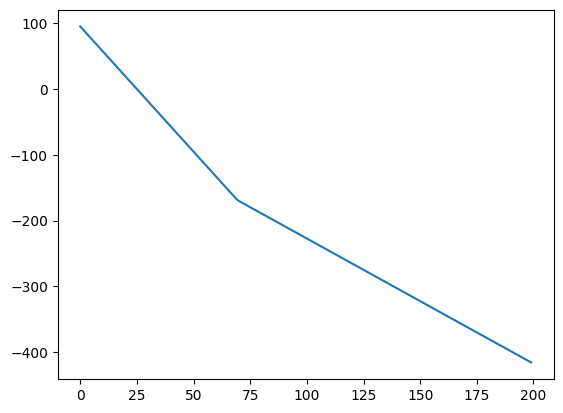

In [403]:
plt.plot(optimal_option.calculate_hedged_position(prices, res.x[0], res.x[1], res.x[2]))

In [318]:
# res[1]

In [320]:
# plt.plot(res[0], res[1])

In [296]:
print(optimal_option)


        isCall: False
        expiration: 0.2053388090349076
        strike: 1650
        amount: 0.2
        initial cost: 95.71973095503861 
        ---
        uniswap_position: lower_price: 1400, upper_price: 1700,
        initial_price: 1540.2467525250313, period_in_years: 0.08213552361396304
        


In [297]:
prices = np.array([price for price in range(500, 2500, 10 )])

pure_usdc = np.array([optimal_option.initial_cost + 
                      uniswap_position.get_total_value(uniswap_position.initial_price) for _ in prices])

In [298]:
optimal_option.initial_cost

95.71973095503861

In [299]:
uniswap_tvs = np.array([uniswap_position.get_total_value(price) for price in prices])
option_pnls = optimal_option.calculate_hedged_position(prices)


In [300]:
earned_fees = 0 # in usdc

In [301]:
# pure_usdc

In [302]:
# uniswap_tvs

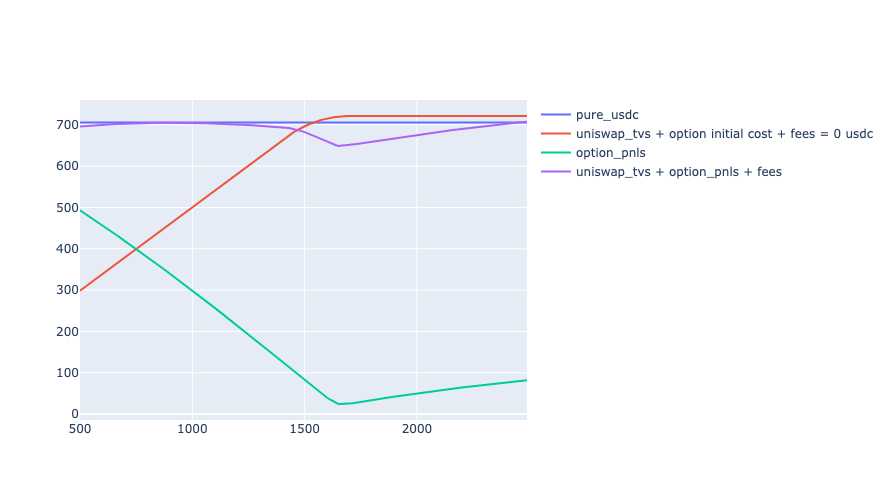

In [303]:
fig = go.Figure()
fig.update_layout(
    autosize=False,
    width=1000,
    height=500)

fig.add_trace(go.Scatter(x=prices, y=pure_usdc,
                    mode='lines',
                    name='pure_usdc'))

fig.add_trace(go.Scatter(x=prices, y=uniswap_tvs + optimal_option.initial_cost + earned_fees,
                    mode='lines',
                    name="""uniswap_tvs + option initial cost + fees = {} usdc""".format(earned_fees)))
fig.add_trace(go.Scatter(x=prices, y=option_pnls,
                    mode='lines',
                    name='option_pnls'))
fig.add_trace(go.Scatter(x=prices, y=uniswap_tvs + option_pnls + earned_fees,
                    mode='lines',
                    name='uniswap_tvs + option_pnls + fees'))

In [120]:
print(optimal_option)


        isCall: False
        expiration: 0.2053388090349076
        strike: 1650
        amount: 1.2
        initial cost: 541.8545477771437 
        ---
        uniswap_position: lower_price: 1500, upper_price: 2000,
        initial_price: 1538.4462402743561, period_in_years: 0.08213552361396304
        


In [159]:
def plot_smile():
    #strikes
    Kn = F * np.linspace(0.5, 2.6, 32)
    c0, iv0 = sabr_0( Kn, F, T )
    plt.figure(figsize=(15, 8))
    ax1 = plt.subplot(2, 2, 1)
    ax1.plot(Kn, c0)
    ax1.grid()
    ax1.set_title("Option price", fontsize=15)
    ax1.set_xlabel("strike", fontsize=12)

    ax2 = plt.subplot(2, 2, 2)
    ax2.plot(Kn, iv0)
    ax2.grid()
    ax2.set_title("IV", fontsize=15)
    ax2.set_xlabel("strike", fontsize=12)

    plt.show()
    None